In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from context import predicate_induction
from predicate_induction import PredicateInduction

The Intel Sensor Dataset is a set of sensor measurements collected from 54 sensors deployed in the Intel Berkeley Research lab between February 28th and April 5th, 2004. Each sensor is assigned an ID (moteid) and collects temperature, humidity, light, and voltage. Additionally, each measurement comes with a timestamp.

The data used in the following example is a sample of ~5000 points from the intel sensor dataset:

In [2]:
data = pd.read_csv('intel_sensor_sample.csv')
data.dtime = pd.to_datetime(data.dtime)

In [3]:
data.head()

,moteid,temperature,humidity,light,voltage,dtime
0,9.0,23.2322,33.3857,1847.36,2.74963,2004-03-02 10:30:23.435732
1,22.0,17.1072,46.2953,71.76,2.58226,2004-03-01 03:18:51.364989
2,11.0,19.5278,41.6461,3.68,2.56000,2004-02-28 19:13:21.006994
3,41.0,18.8418,40.6355,45.08,2.66332,2004-02-28 22:33:19.800370
4,22.0,18.4890,40.5004,0.46,2.60491,2004-02-28 23:45:19.916329


Following [Wu et al.](https://dspace.mit.edu/handle/1721.1/89076), we consider a scenario where an analyst is interested in locating anomalies in temperature. When initializing the PredicateInduction class a dataframe is passed along with the following:

1) model: The anomaly detection algorithm to be used (defaults to the robust covariance model)

2) targets: A list of "target features" where we are looking for anomalies (defaults to all features)

3) specificity: Parameter between 0 and 1. Predicates will cover smaller slices of data the closer this is to 1

In [4]:
pi = PredicateInduction(data, model='robust_cov', targets=['temperature'], specificity=.9)

The ```search_all``` method returns a single predicate consisting of a set of a disjunction of conjunctions. Each conjunction represents an "explanation".

In [5]:
predicate = pi.search_all()

Conjunctions can be accessed using ```predicate.base_predicates```. Each explanation can be visualized:

1) (temperature > 120.547 and temperature <= 122.153)


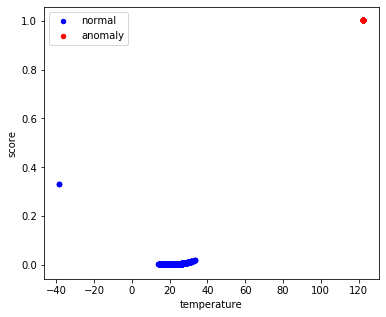

2) (voltage > 2.275 and voltage <= 2.354)


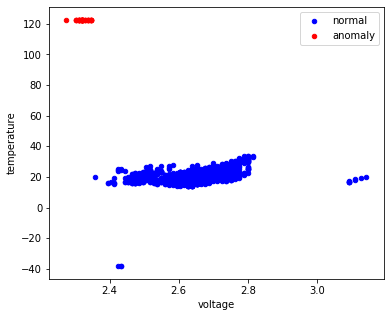

3) moteid in [15.0] and dtime > '2004-03-02 06:53:15.495036032' and dtime <= '2004-03-02 08:47:13.275416064'


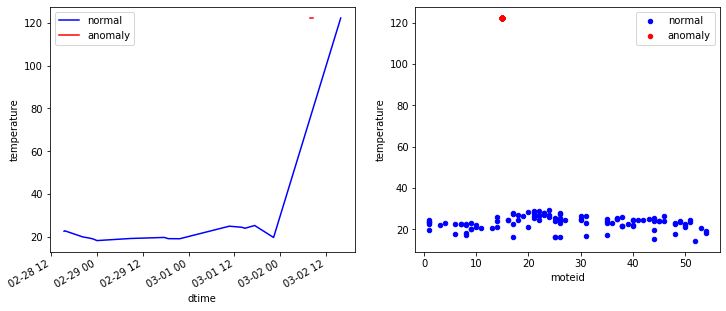

In [6]:
for i in range(len(predicate.base_predicates)):
    p = predicate.base_predicates[i]
    print(f'{i+1})', p)
    d = pi.get_data(p)
    features = p.features
    n = len(features)
    fig, axes = plt.subplots(ncols=n, figsize=(6*n, 5))
    if n == 1:
        axes = [axes]
    for j in range(len(features)):
        feature = features[j]
        cols = d[feature].columns
        if pi.dtypes[feature] == 'date':
            d[feature][d[feature].anomaly==0].set_index(cols[0])[cols[1]].plot(ax=axes[j], color='blue')
            d[feature][d[feature].anomaly==1].set_index(cols[0])[cols[1]].plot(ax=axes[j], color='red')
            axes[j].set_ylabel(cols[1])
            axes[j].legend(['normal', 'anomaly'])
        else:
            d[feature][d[feature].anomaly==0].plot.scatter(x=cols[0], y=cols[1], ax=axes[j], color='blue')
            d[feature][d[feature].anomaly==1].plot.scatter(x=cols[0], y=cols[1], ax=axes[j], color='red')
            axes[j].set_ylabel(cols[1])
            axes[j].legend(['normal', 'anomaly'])
    plt.show()

In addition to the robust covariance model, [isolation forest](https://en.wikipedia.org/wiki/Isolation_forest) and [local outlier factor](https://en.wikipedia.org/wiki/Local_outlier_factor) algorithms are also available:

In [7]:
pi_iso = PredicateInduction(data, model='iso_forest', targets=['temperature'], specificity=.9)
predicate_iso = pi_iso.search_all()

In [8]:
print(predicate_iso)

(temperature > 120.547 and temperature <= 122.153) or (voltage > 2.275 and voltage <= 2.354) or moteid in [15.0] and dtime > '2004-03-02T07:50:14.385226112' and dtime <= '2004-03-02T08:47:13.275416064'


In [9]:
pi_lof = PredicateInduction(data, model='lof', targets=['temperature'], specificity=.9)
predicate_lof = pi_lof.search_all()

In [10]:
print(predicate_lof)

moteid in [51.0] and (humidity > 26.557 and humidity <= 27.145) or moteid in [33.0] and (light > 166.281 and light <= 184.754) or moteid in [33.0] and dtime > '2004-03-01T09:59:39.910856064' and dtime <= '2004-03-01T10:56:38.801046016' or moteid in [51.0] and dtime > '2004-03-02T19:14:01.067506048' and dtime <= '2004-03-02T20:10:59.957696000' or (humidity > 37.135 and humidity <= 37.722) and (voltage > 2.579 and voltage <= 2.588) or (humidity > 37.135 and humidity <= 37.722) and dtime > '2004-03-02T08:47:13.275416064' and dtime <= '2004-03-02T09:44:12.165606016' or (light > 443.382 and light <= 461.855) and dtime > '2004-02-29T11:12:06.546296064' and dtime <= '2004-02-29T12:09:05.436486016' or (light > 240.174 and light <= 258.648) and dtime > '2004-03-02T21:07:58.847886080' and dtime <= '2004-03-02T22:04:57.738076032' or (voltage > 2.579 and voltage <= 2.588) and dtime > '2004-03-01T07:08:43.240286080' and dtime <= '2004-03-01T08:05:42.130476032'
